分类时机器学习中最重要的问题 .

- 对于 1条或者多条数据, 我们想要知道 每条数据代表什么 **类别** 的对象 ;

例如 我们可能需要 1 种算法来查看收件箱的电子邮件数据 .

在 构建用于分类的机器学习算法的时候, 使用真实的数据越多 算法学到的就越多 .

- 在分类任务中 表现得 也越好 !
- 例如, 每当用户将 一封邮件标记为垃圾邮件, 这些数据可以被传回去用来改进算法 ;


我们基于汽车的里程数和价格数据, 算法会给出一个 "是" 或者 "否" 的答案 .

在上一章中, 线性函数时由公式

$$
f(x) = ax + b
$$

中的2个参数 a 和 b 决定的 .

...

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


def plot_function(f, xmin, xmax, **kwargs):
    ts = np.linspace(xmin, xmax, 1000)
    plt.plot(ts, [f(t) for t in ts], **kwargs)


def scalar_field_heatmap(f, xmin, xmax, ymin, ymax, xsteps=100, ysteps=100):
    fig = plt.figure()
    fig.set_size_inches(7, 7)
    fv = np.vectorize(f)
    X = np.linspace(xmin, xmax, xsteps)
    Y = np.linspace(ymin, ymax, ysteps)
    X, Y = np.meshgrid(X, Y)
    z = fv(X, Y)
    fig, ax = plt.subplots()
    c = ax.pcolormesh(X, Y, z, cmap='plasma')
    ax.axis([X.min(), X.max(), Y.min(), Y.max()])
    fig.colorbar(c, ax=ax)


def plot_scalar_field(f, xmin, xmax, ymin, ymax, xsteps=100, ysteps=100, c=None, cmap=cm.coolwarm, alpha=1,
                      antialiased=False, zorder=0):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    # fig = plt.gcf()
    fig.set_size_inches(7, 7)
    # ax = fig.gca(projection='3d')

    fv = np.vectorize(f)

    # Make data.
    X = np.linspace(xmin, xmax, xsteps)
    Y = np.linspace(ymin, ymax, ysteps)
    X, Y = np.meshgrid(X, Y)
    Z = fv(X, Y)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, color=c, alpha=alpha,
                           linewidth=0, antialiased=antialiased, zorder=zorder)

## 1. 用真实的数据来测试分类函数

最简单的例子, 认为宝马比较贵 !.

In [82]:
def bmw_finder(mileage, price):
    if price > 25000:
        return 1
    else:
        return 0

这个函数的表现应该不太行 .

- 当宝马行驶到一定程度就 < 25000 了 ;

我们估算下这个函数用来 衡量算法的效果 . 函数接收 1 个函数 和 测试数据集.

- 返回一个百分比, 说明已经正确的识别了多少的汽车

### 1.1 加载汽车的数据


In [83]:
from chapters.e2.car_data import bmws, priuses

all_car_data = []
for bmw in bmws:
    all_car_data.append((bmw.mileage, bmw.price, 1))
for prius in priuses:
    all_car_data.append((prius.mileage, prius.price, 0))

all_car_data[0]

(93404.0, 13999.0, 1)

### 1.2 测试分类函数

- 如果预测 为宝马, 实际是普锐斯: false positive
- 如果预测 为普锐斯, 实际是宝马: false negative
- 如果预测 是宝马 实际是宝马: true positive
- 如果预测 为普锐斯, 实际是普锐斯: true negative

In [84]:
def test_classifier(classifier, data):
    trues = 0
    falses = 0
    for mileage, price, is_bmw in data:
        if classifier(mileage, price) == is_bmw:  #1
            trues += 1
        else:
            falses += 1  #1
    return trues / (trues + falses)

In [85]:
test_classifier(bmw_finder, all_car_data)

0.59

### 1.3 excrcises

In [86]:
def test_classifier(classifier, data, verbose=False):  #1
    true_positives = 0  #2
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for mileage, price, is_bmw in data:
        predicted = classifier(mileage, price)
        if predicted and is_bmw:  #3
            true_positives += 1
        elif predicted:
            false_positives += 1
        elif is_bmw:
            false_negatives += 1
        else:
            true_negatives += 1

    if verbose:
        print("true positives %f" % true_positives)  #4
        print("true negatives %f" % true_negatives)
        print("false positives %f" % false_positives)
        print("false negatives %f" % false_negatives)

    return (true_positives + true_negatives) / len(data)  #5


test_classifier(bmw_finder, all_car_data, verbose=True)

true positives 18.000000
true negatives 100.000000
false positives 0.000000
false negatives 82.000000


0.59

## 2. 绘制决策边界

### 2.1 绘制汽车的向量空间

In [87]:
def plot_data(ds):
    plt.scatter([d[0] for d in ds if d[2] == 0], [d[1] for d in ds if d[2] == 0], c='C1')
    plt.scatter([d[0] for d in ds if d[2] == 1], [d[1] for d in ds if d[2] == 1], c='C0', marker='x')
    plt.ylabel("Price ($)", fontsize=16)
    plt.xlabel("Odometer (mi)", fontsize=16)

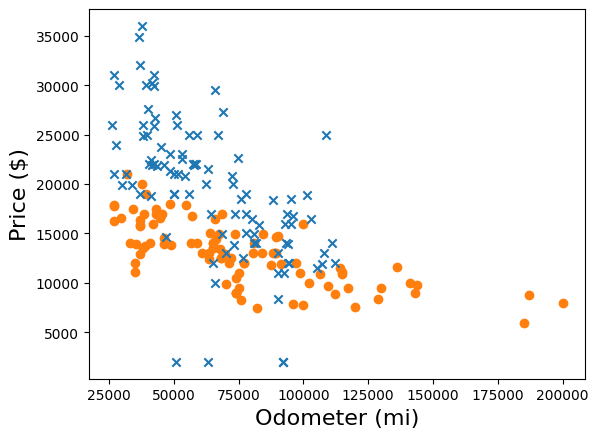

In [88]:
plot_data(all_car_data)

数据集中所有的 xx 是宝马 . 圈圈是普锐斯 .


- 价格上, 宝马更贵

### 2.2 调整决策边界

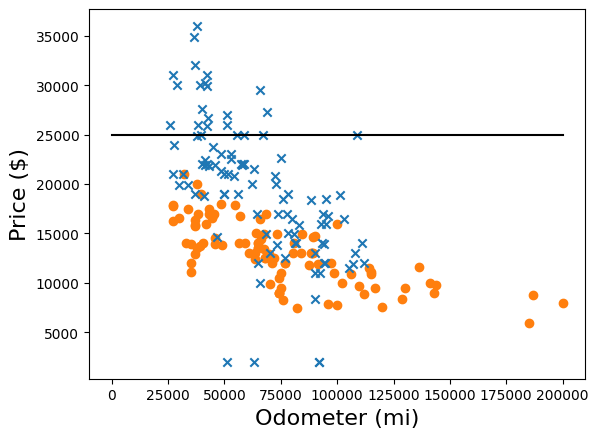

In [89]:
plot_data(all_car_data)
plot_function(lambda x: 25000, 0, 200000, c='k')

而这就是 一条决策边界 .

移动边界 就能提高准确率 .

例如移动到 21_000 处

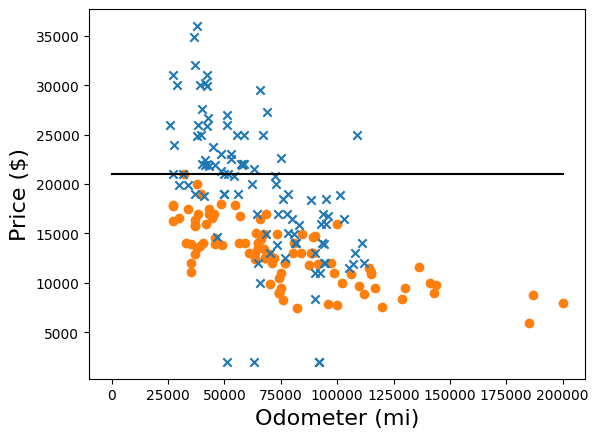

In [90]:
plot_data(all_car_data)
plot_function(lambda x: 21000, 0, 200000, c='k')

再似乎 还可以使用 倾斜的决策边界  纯用肉眼识别 .

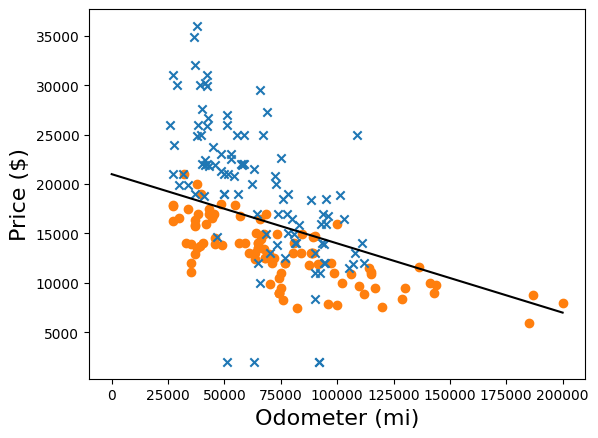

In [91]:
plot_data(all_car_data)
plot_function(lambda x: 21000 - 0.07 * x, 0, 200000, c='k')

### 2.3 实现分类函数

要把决策 边界转换为 分类函数, 需要实现一个 `Python` 函数 .

In [92]:
def decision_boundary_classify(mileage, price):
    if price > 21000 - 0.07 * mileage:
        return 1
    else:
        return 0

In [93]:
test_classifier(decision_boundary_classify, all_car_data)

0.805

这里很容易就想到 把 21_000 和 0.7 去用梯度下降优化下 .

- 当实现 logistic 回归的时候, 其实就是底层用了下 梯度下降移动决策边界 .
- 直到找到 最佳的边界 .


出于  2 个重要的原因 我们会实现更复杂的 logistic 回归算法 .

而不是对决策边界 `ax + b` 的参数 a 和 b 实现梯度下降 .

- 原因1: 如果 决策边界 在梯度下降过程中的 任意一步接近垂直, 则 a 和 b 可能会非常的大, 导致 **数值异常**
- 原因2: 没有明显的代价函数 ;

### 2.4 exercises

**exec1**: ...

In [94]:
def constant_price_classifier(cutoff_price):
    def c(x, p):
        if p > cutoff_price:
            return 1
        else:
            return 0

    return c


def cutoff_accuracy(cutoff_price):
    c = constant_price_classifier(cutoff_price)
    return test_classifier(c, all_car_data)


all_prices = [price for (mileage, price, is_bmw) in all_car_data]
max(all_prices, key=cutoff_accuracy)

17998.0

## 3. 将分类问题构造为 回归问题


回归函数: `logistic_classifier`

- 和之前的分类器相似
- 返回的是 0-1 之间的 1个数, 用来告诉我们这辆车 是宝马的可能性有多大 .

这个标量的意义是 : 宝马的概率. 这个数据多像宝马 .

我们从 猜测良好的 决策边界开始

- .这个直线上方 有较高的 宝马性. 可能是宝马 . 接近 1
- 下方 接近 0
- 决策边界上 = 0.5


### 3.1 缩放原始的汽车数据

In [95]:
def make_scale(data):
    min_val = min(data)  #1 最大值和 最小值
    max_val = max(data)

    def scale(x):  #2 把数据等比缩小到 最大值和最小值中间
        return (x - min_val) / (max_val - min_val)

    def unscale(y):  #3 把缩放后的 0 和 1 的数据点等比的还原 .
        return y * (max_val - min_val) + min_val

    return scale, unscale  #4


price_scale, price_unscale = make_scale([x[1] for x in all_car_data])  # 价格的 2个函数
mileage_scale, mileage_unscale = make_scale([x[0] for x in all_car_data])  # 历程的 2个函数

In [96]:
# 缩放之后的数据
scaled_car_data = [(mileage_scale(mileage), price_scale(price), is_bmw)
                   for mileage, price, is_bmw in all_car_data]

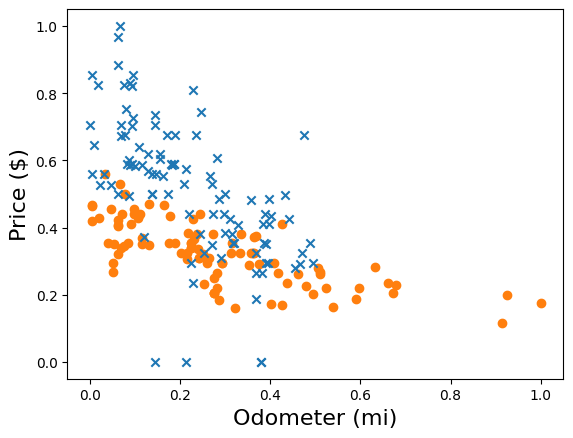

In [97]:
plot_data(scaled_car_data)

从图中看出来非常好 是符合我们需求的 .


### 3.2 衡量汽车的宝马性

$$
p(x) = 0.56 - 0.35 * x
$$

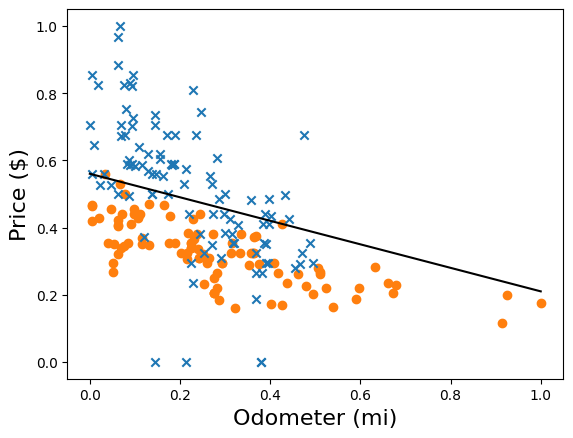

In [98]:
plot_data(scaled_car_data)
plot_function(lambda x: 0.56 - 0.35 * x, 0, 1, c='k')

In [99]:
def bmw_finder(mileage, price):
    if price > 0.56 - 0.35 * mileage:
        return 1
    else:
        return 0


test_classifier(bmw_finder, scaled_car_data)

0.785

我们传入了 缩放数据 和 分类器. 这个决策边界的 分类准确率达到了 78.5 %


函数可以调整 .

$$p = ax + b$$

除了可以看成函数, 还可以看成决策边界的点 (x, p)

$$p - ax - b = 0$$

这个公式的要点是 可以用来度量 .


$$
如果 p - ax - b > 0
$$
则很可能是宝马 .


<Figure size 700x700 with 0 Axes>

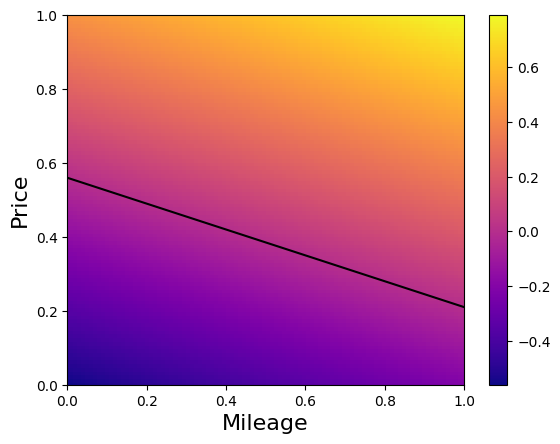

In [100]:
## 我们可以用热力图画出决策边界 . 使用 2 个 a, b 测试下
scalar_field_heatmap(lambda x, p: p + 0.35 * x - 0.56, 0, 1, 0, 1)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Mileage', fontsize=16)
plot_function(lambda x: 0.56 - 0.35 * x, 0, 1, c='k')

这个图很有意思 .

- 上面的点是宝马 .  正宝马性
- 下面的点是边界下 . 负宝马性 .

函数 f(x, p ) 几乎满足要求:

- 同样接受 里程数 和 价格 .

问题是 输出 不是 0 -> 1 .

幸运的事, 数学为我们准备好了 调整输出的函数 .

### 3.3 sigmoid

要做  logistic 回归, 就要用到 logistic 函数 .

基本的 logistic 回归函数如下, 通常称为 : `sigmoid` 函数 .

$$
\sigma(x) = \frac {1}{1 + e^{-x}}
$$

In [101]:
from math import exp


def sigmoid(x):
    return 1 / (1 + exp(-x))

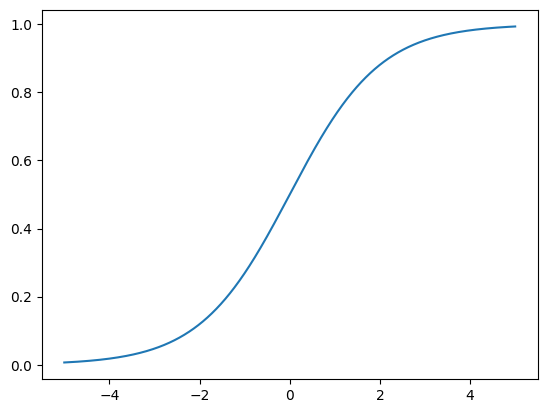

In [102]:
plot_function(sigmoid, -5, 5)

这是个 著名的函数, 常用于线性回归. 有如下的 `features` :

- 输入的数会 转换为 一个介于 0-1  之间的值 .
- 大的负数接近 0
- 大的正数接近 1
- 0 是 0.5

简单来说 就是正无穷到负无穷 扣到 0 - 1

### 3.4 sigmoid 函数和其他函数的配合

回到
$$
f(x, p) = p -ax - b
$$

接收 历程值 和 价格值 .

$$
L(x, p) = \sigma(f(x, p))
$$

<Figure size 700x700 with 0 Axes>

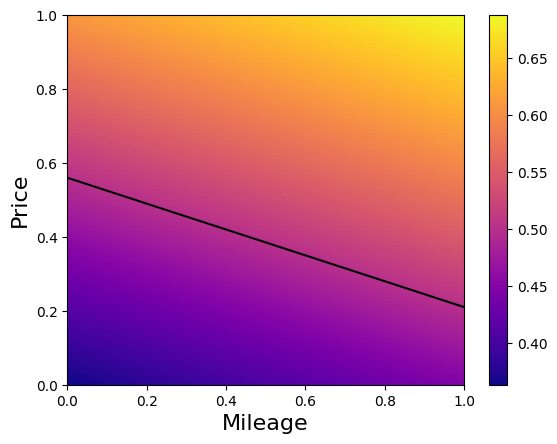

In [103]:
def f(x, p):
    return p + 0.35 * x - 0.56


def l(x, p):
    return sigmoid(f(x, p))


# 绘制热图
scalar_field_heatmap(l, 0, 1, 0, 1)
# plot_data(scaled_car_data,white=True)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Mileage', fontsize=16)
plot_function(lambda x: 0.56 - 0.35 * x, 0, 1, c='k')

和前面的对比看, 热图没有什么不同, 同向增长, 数值不同 到了 0.40 左右 ..

有趣的是 可以放到三维空间来看 .

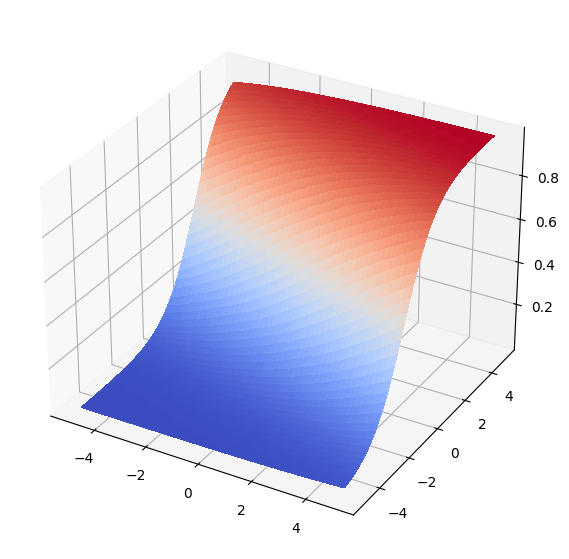

In [105]:
plot_scalar_field(l, -5, 5, -5, 5)

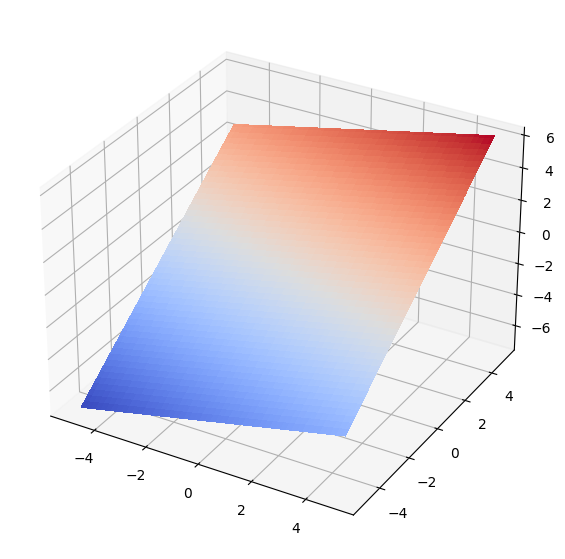

In [106]:
plot_scalar_field(f, -5, 5, -5, 5)

从三维图的特征来看:

- f(x, p) 线性上升
- 而 l(x,p) 则是从 0 弯曲到 1

因为 0,1 表示汽车的类型, f(x, p) 的值走向的是正负无穷 .
l(x, p) 则是接近这些数 .

可以用 三维图来加深理解 .

在 `scaled_car_data` 中

- 普锐斯 -> (mileage, price, 0)
- 宝马 -> (mileage, prices , 1)

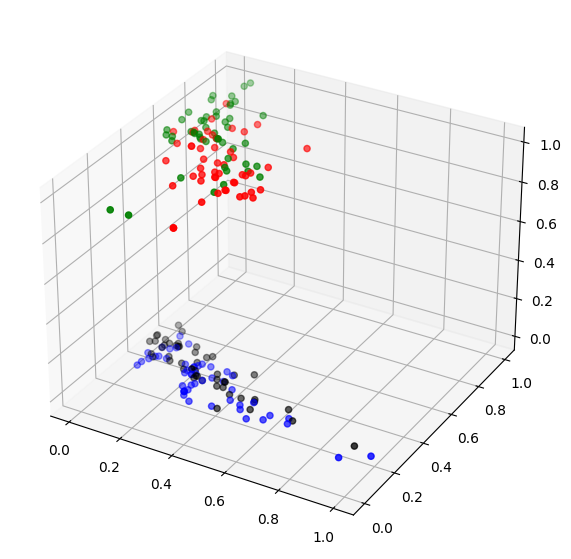

In [120]:


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# fig = plt.gcf()
fig.set_size_inches(7, 7)

colors = ('r', 'g', 'b', 'k')
xs = [x for (x, _, _) in scaled_car_data]
ys = [y for (_, y, _) in scaled_car_data]
zs = [z for (_, _, z) in scaled_car_data]
c_list = []
for c in colors:
    c_list.extend([c] * 50)
ax.scatter(xs, ys, zs, c=c_list)




这些点可能更 拟合 .

### 3.5 exercises

....

## 4. 探索可能得 logistic 函数

我们快速的回顾一下所有的步骤 ...

1. 在散点图上绘制 普瑞斯和宝马的 里程数和价格 . 肉眼识别
2. 尝试在这些点中画 1些直线 我们称为决策边界, 他定义了区分的规则


我们需要的不是通过观察得到的 L(x, p) .

实际上, 可以用 3个参数来编写通用的 logistic 函数 .

下面的步骤大概率就是通过  梯度下降来探索三维空间了. 定义 logistic_cost(a, b, c) 函数找最小值

### 4.1 参数化 logistic 函数 .

$$
z(x, p) = ax + bp - c
$$

$$
L(x, p) = \sigma{ax + bp - c}
$$

In [ ]:
def make_logistic(a, b, c):
    def l(x, p):
        return sigmoid(a * x + b * p - c)

    return l

### 4.2 衡量 logistic 函数的 拟合质量

- 任意一辆宝马对应 `scaled_car_data` 列表中形式为 (x, p, 1) 的项 ;
- 任意一辆普锐斯对应 `scaled_car_data` 列表中形式为 (x, p, 0) 的项 ;

最简单的方法是：

- 找到 和 (0|1) 正确值的误差 .

In [121]:
def simple_logistic_cost(a, b, c):
    l = make_logistic(a, b, c)
    errors = [abs(is_bmw - l(x, p))
              for x, p, is_bmw in scaled_car_data]
    return sum(errors)

这个代价函数 很好的报告了误差, 但是不足以让梯度下降收敛到 a,b,c .是不可用的 .

大概得思路如下. 假设有 2 个 logistic 函数 L1, 和 L2 .

对相同的数据点 (x,p,0) 也就是普林斯 .

- L1(x, p) 返回 0.99 > 0.5 . 因此是错误的 . 误差是 0.99
- L2(x, p) 预测是 0.999 就更离谱

简单来看, L2 错了 10 倍 .但是值都很小

我们要创建一个代价函数, 使得如果 L(x, p) 预测了错误的答案, 那么 L 的代价就会很高 .

- 一个较好的让小的值变大的函数时 `-log(x)` . 可以让 较小的值变大增加惩罚 .


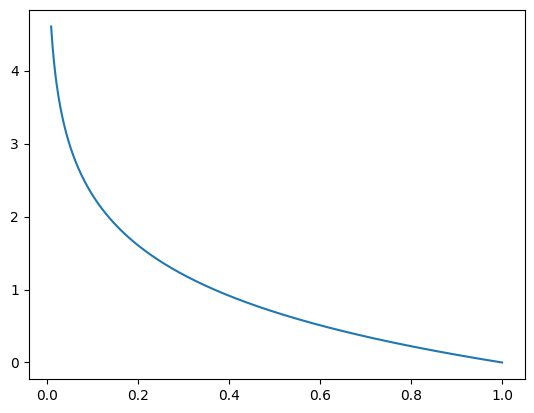

In [122]:
from math import log

plot_function(lambda x: -log(x), 0.01, 1)

In [123]:
print(
    f"""
    0.01 -> {-log(0.01)},
    0.001 -> {-log(0.001)},
    """
)


    0.01 -> 4.605170185988091,
    0.001 -> 6.907755278982137,
    


In [ ]:
def point_cost(l, x, p, is_bmw):  #1 每个点的误差 .
    wrong = 1 - is_bmw  # 1 - 是因为 l 是反了的吧 .
    return -log(abs(wrong - l(x, p)))


## 0 测试数据
## 真实 = 0 . 1-0 = 1 abs(1-0) = 1>
## 真实 = 1 .  1-1 = 0
def logistic_cost(a, b, c):
    l = make_logistic(a, b, c)
    errors = [point_cost(l, x, p, is_bmw)  #2
              for x, p, is_bmw in scaled_car_data]
    return sum(errors)

在使用 梯度下降法前先测试下 cost function 是否收敛 .

$$
p = 0.56 - 0.35 \cdot x
$$

$$
x + p  = 1
$$

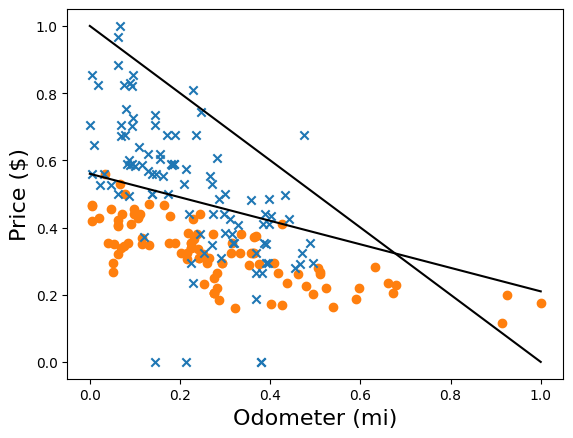

In [126]:
def plot_line(acoeff, bcoeff, ccoeff, **kwargs):
    a, b, c = acoeff, bcoeff, ccoeff

    # black by default
    if 'c' not in kwargs:
        kwargs['c'] = 'k'

    if b == 0:
        plt.plot([c / a, c / a], [0, 1])
    else:
        def y(x):
            return (c - a * x) / b

        plt.plot([0, 1], [y(0), y(1)], **kwargs)


plot_data(scaled_car_data)
plot_line(0.35, 1, 0.56, )
plot_line(1, 1, 1)